Let's load the entire dataset

In [13]:
import json

with open('wizard_of_wikipedia/data.json') as f:
    data = json.load(f)

In [20]:
import numpy as np
parsed_data = [
    {
        'topic': sample['chosen_topic'],
        'dialogue': '\n'.join([utterance['text'] for utterance in sample['dialog']])
    }
for sample in data]
parsed_data = [(sample['topic'], sample['dialogue']) for sample in parsed_data]

In [3]:
from sentence_transformers import SentenceTransformer, CrossEncoder

semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [21]:
import pickle

def encode(parsed_data=parsed_data, semb_model=semb_model):
    try:
        with open('dumps/sentence_clustering/embeddings.pkl', 'rb') as f:
            return pickle.load(f)
    except:
        embeddings = [semb_model.encode(sample) for sample in parsed_data]
        with open('dumps/sentence_clustering/embeddings.pkl', 'wb') as f:
            pickle.dump(embeddings, f)
        return embeddings

In [28]:
embeddings = encode()

In [31]:
embeddings = np.array(embeddings).mean(axis=1)
embeddings.shape

(22311, 384)

Project the embeddings on a 2D space

In [34]:
# Project embeddings to 2D space by using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(embeddings)
embeddings_2d = pca.transform(embeddings)

In [36]:
print('The topics are:')
print(list(set([sample[0] for sample in parsed_data])))

The topics are:
['Rock climbing', 'Grilling', 'Lightning McQueen', 'Cabernet Sauvignon', 'Parrot', 'Volunteering', 'Cabana boy', 'Spider', 'Hip hop music', 'Racquetball', 'Violin', 'System of a Down', 'Hiking', 'Cruise ship', 'Honda Civic', 'Animals in sport', 'Red wine', 'Spider-Man', 'Cat', 'Santa Fe, New Mexico', 'Online game', 'Truck driver', 'Scotch whisky', 'Piccadilly Circus', 'Anthony Michael Hall', 'Baltimore Orioles', 'Cheese', 'Animal print', 'Cue sports', 'Equestrianism', 'Alcoholism', 'Thursday', 'Philip Larkin', 'Allergy', 'Wheelchair', '100 metres', 'Robert De Niro', 'Swing (dance)', 'Southwest Airlines', 'Game design', 'Family Guy', 'Parisian café', 'Botulinum toxin', 'Barbershop music', 'Ivy League', 'Laziness', 'Country', 'Ultimate (sport)', 'Consulting firm', 'Graphic design', 'Toto (band)', 'PlayStation', 'Kurt Cobain', 'Beadwork', 'Gospel music', 'Winter', 'Christianity', 'Nachos', 'Hop Along', 'Country music', 'Avengers (comics)', 'Ice hockey', 'The Royal Ballet',

In [64]:
# Topic search bar
# Take input from user
topic = input('Enter topic: ')

# Find all topics with similar name
topics = [sample[0] for sample in parsed_data]
topics = set([t for t in topics if topic.lower() in t.lower()])

print('Found topics:')
print(list(topics))

Found topics:
['Depression (mood)']


Choose a topic and plot the embeddings

33 dialogues found with that topic.


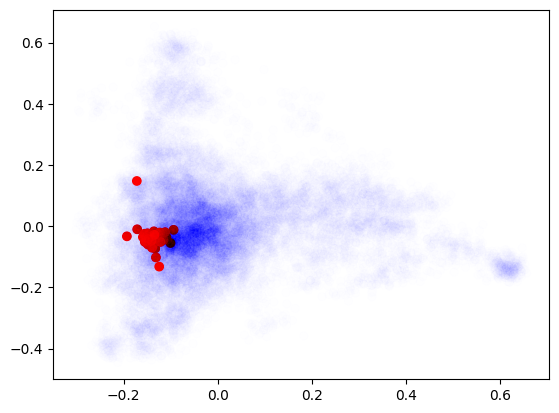

In [65]:
# Scatter the embeddings, highlight the chosen topic in red
import matplotlib.pyplot as plt

topic = 'Depression (mood)'
n_dialogues = len([sample for sample in parsed_data if sample[0] == topic])
print(f'{n_dialogues} dialogues found with that topic.')
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=['r' if sample[0] == topic else 'b' for sample in parsed_data], alpha=[1 if sample[0] == topic else 0.005 for sample in parsed_data])
plt.show()

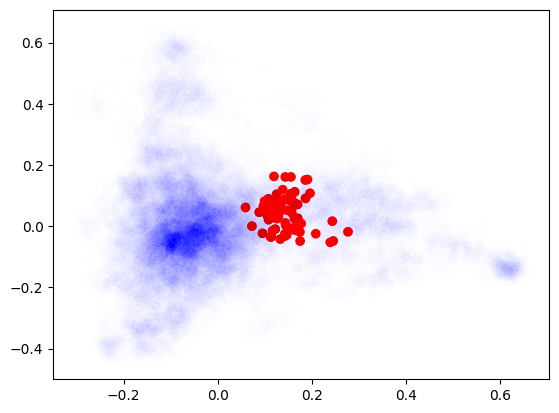

Counter({'Fruit picking': 19, 'Orange juice': 17, 'Pickling': 12, 'Strawberry': 10, 'Banana': 5, 'Pickled cucumber': 5, 'Juicing': 3, 'Fruitarianism': 2})


In [86]:
# Try unsupervised clustering
from sklearn.cluster import KMeans

n_topics = len(set([sample[0] for sample in parsed_data]))
def cluster(embeddings=embeddings, n_clusters=100):
    try:
        with open('dumps/sentence_clustering/kmeans.pkl', 'rb') as f:
            return pickle.load(f)
    except:
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(embeddings)
        with open('dumps/sentence_clustering/kmeans.pkl', 'wb') as f:
            pickle.dump(kmeans, f)
        return kmeans
    
kmeans = cluster(n_clusters=400)

k = 139

# Scatter the embeddings, highlight the chosen cluster label k in red
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=['r' if label == k else 'b' for label in kmeans.labels_], alpha=[1 if label == k else 0.005 for label in kmeans.labels_])
plt.show()

# Print the names of the topics in red
from nltk import Counter
topics = [sample[0] for i, sample in enumerate(parsed_data) if kmeans.labels_[i] == k]
print(Counter(topics))